In [1]:
import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from optimization import (SequenceSignal, 
                          transformer_model, 
                          train_val_loops)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (precision_score, recall_score, auc, 
                             precision_recall_curve, PrecisionRecallDisplay)

In [2]:
# Global variables
DATA_DIR=Path('../ML_datasets/CRE_data/')
X_TRAIN_PATH = DATA_DIR.joinpath('dataset_1kb_dELSs_train_augmented_encoding.npy')
Y_TRAIN_PATH = DATA_DIR.joinpath('train_target.npy')
X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_dELSs_val_encoding.npy')
Y_VAL_PATH = DATA_DIR.joinpath('val_target.npy')
N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]
N_TRAIN_EXAMPLES = np.load(Y_TRAIN_PATH).shape[0]

BATCH_SIZE = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
                                          Y_TRAIN_PATH, 
                                          X_VAL_PATH, 
                                          Y_VAL_PATH, 
                                          BATCH_SIZE, 
                                          device = DEVICE)

In [3]:
N_EPOCHS = 30
PATIENCE = 20
OUTPUT_SHAPE = 9

epsilon = 1e-6
n_pos = np.load(Y_TRAIN_PATH).sum(axis=0)
n_neg = (1.0 - np.load(Y_TRAIN_PATH)).sum(axis=0)
pos_weight = n_neg / (n_pos + epsilon)
pos_weight = torch.Tensor(pos_weight).to(DEVICE)
pos_weight = torch.log1p(pos_weight).to(DEVICE)

#CRITERION = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weight)
CRITERION = torch.nn.BCEWithLogitsLoss()
CHECKPOINT_NAME = DATA_DIR.joinpath('best_model_dELSs.pth')
PRETRAINED_WEIGHTS = '../ML_datasets/ATAC_data/ATAC_transformer.pth'
USE_PRETRAIN = True

model = transformer_model.TransformerCNNMixtureModel(n_conv_layers = 4, 
                                                     n_filters = [256, 60, 60, 120], 
                                                     kernel_sizes = [7, 3, 5, 3], 
                                                     dilation = [1, 1, 1, 1], 
                                                     drop_conv = 0.1, 
                                                     n_fc_layers = 2, 
                                                     drop_fc = 0.4, 
                                                     n_neurons = [256, 256], 
                                                     output_size = OUTPUT_SHAPE, 
                                                     drop_transformer=0.2, 
                                                     input_size=4, 
                                                     n_encoder_layers = 2, 
                                                     n_heads=8, 
                                                     n_transformer_FC_layers=256)

model.to(device=DEVICE)

if USE_PRETRAIN:
    training_state = torch.load(PRETRAINED_WEIGHTS, 
                                weights_only = True, 
                                map_location = DEVICE)
    model.load_state_dict(training_state['network'])

summary(model)

Layer (type:depth-idx)                                            Param #
TransformerCNNMixtureModel                                        --
├─ModuleList: 1-1                                                 --
│    └─Sequential: 2-1                                            --
│    │    └─ConvPoolingBlock: 3-1                                 7,936
│    └─Sequential: 2-2                                            --
│    │    └─ConvPoolingBlock: 3-2                                 46,260
│    └─Sequential: 2-3                                            --
│    │    └─ConvPoolingBlock: 3-3                                 18,180
│    └─Sequential: 2-4                                            --
│    │    └─ConvPoolingBlock: 3-4                                 21,960
├─PositionalEncoding: 1-2                                         --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─Tr

In [4]:
torch.log1p(pos_weight)

tensor([1.2000, 1.0710, 1.0044, 0.7864, 0.8360, 0.8485, 0.8522, 0.9153, 1.0021],
       device='cuda:0')

In [5]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 1e-3, weight_decay = 5e-4)
print(optimizer)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0005
)


In [7]:
if not os.path.exists(CHECKPOINT_NAME):
    
    output = train_val_loops.train_N_epochs(model, optimizer, 
                                            criterion = CRITERION, 
                                            train_loader = dataloaders[0], 
                                            valid_loader = dataloaders[1], 
                                            num_epochs = N_EPOCHS, 
                                            patience = PATIENCE, 
                                            model_path = CHECKPOINT_NAME, 
                                            lr_scheduler = None, 
                                            DEVICE = DEVICE)
else:
    
    training_state = torch.load(CHECKPOINT_NAME, 
                                weights_only = True, 
                                map_location = DEVICE)
    
    model.load_state_dict(training_state['network'])

In [8]:
X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_dELSs_test_encoding.npy')
Y_VAL_PATH = DATA_DIR.joinpath('test_target.npy')
N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]

dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
                                          Y_TRAIN_PATH, 
                                          X_VAL_PATH, 
                                          Y_VAL_PATH, 
                                          BATCH_SIZE, 
                                          device = DEVICE)
Y_PREDICT_PATH = DATA_DIR.joinpath('y_predict_dELSs.npy')

model.eval()
y_predict = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
y_true = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        y_predict[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = model(inputs)
        y_true[(i * BATCH_SIZE):(i * BATCH_SIZE + BATCH_SIZE)] = labels

y_true_array = y_true.cpu().numpy()
print(CRITERION(y_predict, y_true))
y_predict = nn.functional.softmax(y_predict, dim=1)
y_predict_array = (y_predict).cpu().numpy()
np.save(Y_PREDICT_PATH, y_predict_array)

tensor(0.3813, device='cuda:0')


0.23986224783695734
0.3777748496363511
0.3913439047489562
0.6162308597342735
0.6688759759620446
0.46674828105739796
0.5857988041895785
0.5749664249803739
0.28185744705921045


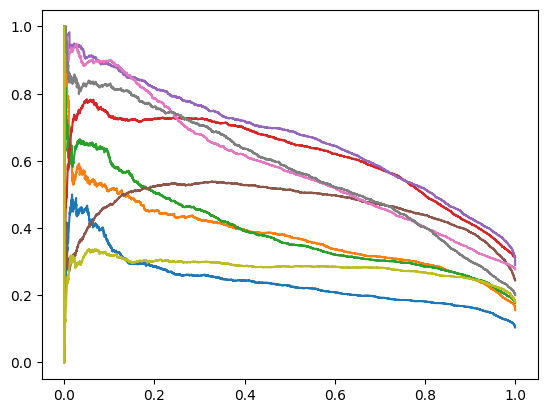

In [9]:
for j in range(OUTPUT_SHAPE):
    y, x, _ = precision_recall_curve(y_true_array[:, j], y_predict_array[:, j])
    plt.plot(x, y)
    print(auc(x, y))

In [28]:
from optimization.SequenceSignal import Sequence
from torch.utils.data import DataLoader
val = Sequence('../WID_specific_enhancers_peaks_encoding.npy', device = DEVICE)
size = len(val)
val = DataLoader(val, batch_size = BATCH_SIZE, shuffle = False)

model.eval()
y_predict = torch.zeros((size, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():

    for i, data in enumerate(val, 0):
        outputs = model(data)

        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE

        y_predict[start_idx:end_idx] = outputs
        
y_predict_array_CREsS_specific = y_predict.cpu().numpy()

In [23]:
scores_ATAC = y_predict_array_ATAC[:, 5]
scores_enhancers = y_predict_array_CREs[:, 5]

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (9).

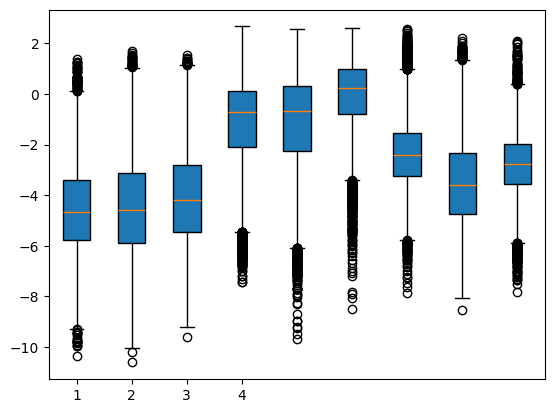

In [34]:
plt.boxplot(y_predict_array_CREsS_specific, patch_artist=True)

plt.xticks(range(1, data.shape[1] + 1), [f'Var {i+1}' for i in range(y_predict_array_CREsS_specific.shape[1])])
plt.ylabel('Values')
plt.title('Boxplots of 9 Variables')
plt.show()